# Day 0: Imports and Utility Functions

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import math
import numpy as np
import os
import operator
import re
import random
import string
import collections, itertools, functools, heapq, operator, bisect
from collections import Counter, defaultdict, namedtuple, deque, OrderedDict
from functools   import lru_cache, reduce
from statistics  import mean, median, mode, stdev, variance
from itertools   import (permutations, combinations, groupby, repeat,
                         islice, repeat,cycle, chain, product, zip_longest, takewhile, dropwhile, count as count_from)
from heapq       import heappush, heappop, heapify
from operator    import iand, ior, ilshift, irshift
from bisect      import bisect_left, bisect_right

In [2]:
input_path = lambda day : "inputs/day{}.txt".format(day)
input_path_sample = lambda day : "inputs/day{}-sample.txt".format(day)

In [3]:
def get_ints(f):
    """extract ints from a file."""
    return map(int, re.findall(r'[+-]?[0-9]+', f.read()))

# [Day 1: The Tyranny of the Rocket Equation](https://adventofcode.com/2019/day/1)

In [4]:
with open(input_path(1), 'r') as f:
    fuel = sum(mass // 3 - 2 for mass in get_ints(f))
print(fuel)

3160932


In [5]:
def compute_fuel(mass):
    """compute fuel needed."""
    ans = 0
    while True:
        mass = mass // 3 - 2
        if mass <= 0:
            break
        ans += mass
    return ans

In [6]:
assert(compute_fuel(100756) == 50346)
assert(compute_fuel(14) == 2)
assert(compute_fuel(1969) == 966)

In [7]:
with open(input_path(1), 'r') as f:
    fuel = sum(compute_fuel(mass) for mass in get_ints(f))
print(fuel)

4738549


# [Day 2: 1202 Program Alarm](https://adventofcode.com/2019/day/2)

In [8]:
def parse_code(code):
    """simple code parser."""
    import operator
    n = len(code)
    for i in range(0, n, 4):
        opcode = code[i]
        if opcode == 99:
            break
        else:
            left_idx = code[i + 1]
            right_idx = code[i + 2]
            r_idx = code[i + 3]
            op = operator.add if opcode == 1 else operator.mul
            code[r_idx] = op(code[left_idx], code[right_idx])
    return code

In [9]:
assert(parse_code([1,0,0,0,99]) == [2,0,0,0,99])
assert(parse_code([2,3,0,3,99]) == [2,3,0,6,99])
assert(parse_code([2,4,4,5,99,0]) == [2,4,4,5,99,9801])
assert(parse_code([1,1,1,4,99,5,6,0,99]) == [30,1,1,4,2,5,6,0,99])

In [10]:
with open(input_path(2), 'r') as f:
    memory = list(get_ints(f))
code = memory[:]
code[1] = 12
code[2] = 2
print(parse_code(code)[0])

2890696


In [11]:
def choose_noun_and_verb(memory, target):
    """search inputs."""
    n = len(memory)
    for noun in range(n):
        for verb in range(n):
            code = memory[:]
            code[1] = noun
            code[2] = verb
            if parse_code(code)[0] == target:
                return noun, verb
    return None

In [12]:
target = 19690720
noun, verb = choose_noun_and_verb(memory, target)
print(100 * noun + verb)

8226


# [Day 3: Crossed Wires](https://adventofcode.com/2019/day/3)

In [13]:
with open(input_path(3), 'r') as f:
    paths = [tuple(token for token in line.split(',')) for line in f]
path1, path2 = paths

In [14]:
def compute_wire(path):
    """compute wire generated by path"""
    moves = dict(zip("LRUD", ((-1, 0), (1, 0), (0, 1), (0, -1))))
    x, y = 0, 0
    wire = {}
    steps = 0
    for item in path:
        d, cnt = item[0], int(item[1:])
        dx, dy = moves[d]
        for i in range(cnt):
            if (x, y) not in wire:
                wire[x, y] = steps
            x, y = x + dx, y + dy
            steps += 1
    return wire

In [15]:
wire1, wire2 = compute_wire(path1), compute_wire(path2)

In [16]:
print(min(abs(x) + abs(y) for x, y in wire1.keys() & wire2.keys() if x != 0 and y != 0))

232


In [17]:
print(min(wire1[key] + wire2[key] for key in wire1.keys() & wire2.keys() if key != (0, 0)))

6084


# [Day 4: Secure Container](https://adventofcode.com/2019/day/4)

In [18]:
def valid_passwd(pw):
    """check if a passwd is valid."""
    pre = 10
    has_double = False
    while pw:
        d = pw % 10
        if pre != 10:
            if pre == d:
                has_double = True
            if pre < d:
                return False
        pre = d
        pw //= 10
    return has_double

In [19]:
lo_pw = 245182
hi_pw = 790572
print(sum(valid_passwd(pw) for pw in range(lo_pw, hi_pw + 1)))

1099


In [20]:
def valid_passwd_new(pw):
    """check if a passwd is valid."""
    pw_str = str(pw)
    pre = None
    has_double = False
    for ch, g in itertools.groupby(pw_str):
        cnt = len(list(g))
        if pre and ch < pre:
            return False
        if cnt == 2:
            has_double = True
        pre = ch
    return has_double

In [21]:
print(sum(valid_passwd_new(pw) for pw in range(lo_pw, hi_pw + 1)))

710


# [Day 5: Sunny with a Chance of Asteroids](https://adventofcode.com/2019/day/5)

In [22]:
with open(input_path(5), 'r') as f:
    code5 = list(get_ints(f))

In [23]:
class Input:
    """Input stream for the IntCode Program."""
    def __init__(self, vals):
        self.stream = collections.deque(vals)
    
    def feed(self, val):
        self.stream.append(val)
        
    def next_input(self):
        return self.stream.popleft()

In [24]:
class Program:
    """IntCode Program"""
    def __init__(self, code, inputs):
        self.code = code[:]
        self.inputs = inputs
        self.relative_base = 0
        self.genor = self.run()
        
    def feed(self, val):
        self.inputs.feed(val)
    
    def run(self):
        """Generate output."""
        memory = collections.defaultdict(int)
        for j, c in enumerate(self.code):
            memory[j] = c
        pc = 0
        def get_operand(para, mode):
            """mode: 0 position; 1 value; 2 relative position"""
            if mode == 2:
                para += self.relative_base
                return memory[para]
            return memory[para] if mode == 0 else para
        def get_save_idx(para, mode):
            """mode: 0 absolute, 2 relative"""
            return para if mode == 0 else para + self.relative_base
        while True:
            assert(memory[pc] >= 0)
            instruct = "{:05d}".format(memory[pc])
            assert(len(instruct) == 5)
            opcode = int(instruct[-2:])
            first_mode = int(instruct[2])
            second_mode = int(instruct[1])
            third_mode = int(instruct[0])
            if opcode == 99:
                break
            elif opcode == 3:
                # input
                memory[get_save_idx(memory[pc + 1], first_mode)] = self.inputs.next_input()
                pc += 2
            elif opcode == 4:
                # output
                out = get_operand(memory[pc + 1], first_mode)
                pc += 2
                yield out
            elif opcode == 1 or opcode == 2:
                # addition and multiplication
                op = operator.mul if opcode == 2 else operator.add
                val = op(get_operand(memory[pc + 1], first_mode), get_operand(memory[pc + 2], second_mode))
                memory[get_save_idx(memory[pc + 3], third_mode)] = val
                pc += 4
            elif opcode == 5:
                # jump is true
                first_operand = get_operand(memory[pc + 1], first_mode)
                if first_operand != 0:
                    pc = get_operand(memory[pc + 2], second_mode)
                else:
                    pc += 3
            elif opcode == 6:
                # jump if false
                first_operand = get_operand(memory[pc + 1], first_mode)
                if first_operand == 0:
                    pc = get_operand(memory[pc + 2], second_mode)
                else:
                    pc += 3
            elif opcode == 7:
                if get_operand(memory[pc + 1], first_mode) < get_operand(memory[pc + 2], second_mode):
                    memory[get_save_idx(memory[pc + 3], third_mode)] = 1
                else:
                    memory[get_save_idx(memory[pc + 3], third_mode)] = 0
                pc += 4
            elif opcode == 8:
                if get_operand(memory[pc + 1], first_mode) == get_operand(memory[pc + 2], second_mode):
                    memory[get_save_idx(memory[pc + 3], third_mode)] = 1
                else:
                    memory[get_save_idx(memory[pc + 3], third_mode)] = 0
                pc += 4
            elif opcode == 9:
                self.relative_base += get_operand(memory[pc + 1], first_mode)
                pc += 2
            else:
                assert False, "Unkown opcode {}".format(opcode)

In [25]:
list(Program(code5, Input([1])).genor)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 6731945]

In [26]:
test_in = [3,21,1008,21,8,20,1005,20,22,107,8,21,20,1006,20,31,
1106,0,36,98,0,0,1002,21,125,20,4,20,1105,1,46,104,
999,1105,1,46,1101,1000,1,20,4,20,1105,1,46,98,99]
assert(list(Program(test_in, Input([7])).genor)[-1] == 999)

In [27]:
list(Program(code5, Input([5])).genor)[-1]

9571668

# [Day 6: Universal Orbit Map](https://adventofcode.com/2019/day/6)

In [28]:
def count_orbits(infile):
    """count number of orbits."""
    import collections
    tree = collections.defaultdict(list)
    with open(infile, 'r') as f:
        for line in f:
            u, v = line.strip().split(')')
            tree[u].append(v)
    norbits = 0
    def dfs(node, depth):
        nonlocal norbits
        norbits += depth
        for child in tree[node]:
            dfs(child, depth + 1)
    dfs('COM', 0)
    return norbits

In [29]:
# print(count_orbits(input_path_sample(6)))
assert(count_orbits(input_path_sample(6)) == 42)

In [30]:
print(count_orbits(input_path(6)))

301100


In [31]:
def find_path(infile, target="SAN"):
    """find path between YOU and target."""
    import collections
    tree = collections.defaultdict(list)
    with open(infile, 'r') as f:
        for line in f:
            u, v = line.strip().split(')')
            tree[u].append(v)
            tree[v].append(u)
    frontier = [("YOU", None, 0)]
    while frontier:
        node, parent, depth = frontier.pop()
        if node == target:
            return depth - 2
        for nei in tree[node]:
            if nei != parent:
                frontier.append((nei, node, depth + 1))

In [32]:
print(find_path(input_path(6)))

547


# [Day 7: Amplification Circuit](https://adventofcode.com/2019/day/7)

In [33]:
with open(input_path(7), 'r') as f:
    code7 = list(get_ints(f))

In [34]:
def amplify_circuit(code):
    """implement amplify circuit."""
    def amplify(setting):
        signal = 0
        for inst in setting:
            amp = Program(code, Input([inst, signal]))
            signal = next(amp.genor)
        return signal
    return max(amplify(setting) for setting in permutations(range(5)))

In [35]:
print(amplify_circuit(code7))

21000


In [36]:
def feedback_amplify_circuit(code):
    """implement feedback amplify circuit."""
    def amplify(setting):
        amps = [Program(code, Input([inst])) for inst in setting]
        ans = None
        signal = 0
        while True:
            for i, amp in enumerate(amps):
                amps[i].inputs.feed(signal)
                signal = next(amp.genor, None)
                if signal is None:
                    return ans
                if i == 4:
                    ans = signal
    return max(amplify(setting) for setting in permutations(range(5, 10)))            

In [37]:
assert(feedback_amplify_circuit([3,26,1001,26,-4,26,3,27,1002,27,2,27,1,27,26,27,4,27,
                                 1001,28,-1,28,1005,28,6,99,0,0,5]) == 139629729)

In [38]:
assert(feedback_amplify_circuit([3,52,1001,52,-5,52,3,53,1,52,56,54,1007,54,5,55,1005,55,26,1001,54,
-5,54,1105,1,12,1,53,54,53,1008,54,0,55,1001,55,1,55,2,53,55,53,4,
53,1001,56,-1,56,1005,56,6,99,0,0,0,0,10]) == 18216)

In [39]:
print(feedback_amplify_circuit(code7))

61379886


# [Day 8: Space Image Format](https://adventofcode.com/2019/day/8)

In [40]:
WIDTH = 25
HEIGHT = 6
with open(input_path(8), 'r') as f:
    image = f.read().strip()
n = len(image)
assert(n % (WIDTH * HEIGHT) == 0)
assert(image.isdigit())

In [41]:
PIXELS = WIDTH * HEIGHT
counter = [PIXELS + 1] * 10
for i in range(n // (PIXELS)):
    temp = [0] * 10
    start = i * PIXELS
    for i in range(start, start + PIXELS):
        pix = image[i]
        temp[ord(pix) - ord('0')] += 1
    if temp[0] < counter[0]:
        counter = temp
print(counter[1] * counter[2])

1360


In [42]:
def decode_image(image, width=25, height=6):
    """decode and plot image."""
    n = len(image)
    total = width * height
    ans = [next(itertools.dropwhile(lambda x : x == '2', (image[j] for j in range(i, n, total))) ) for i in range(total)]
    fig, ax = plt.subplots(figsize=(10, 10))
    for row in range(height):
        line = ''.join(ans[row * width: row * width + width])
        y = height - 1 - row
        for x, val in enumerate(line):
            if val == '1':
                ax.scatter(x, y, color='b')
    ax.axis('equal')
    plt.show()
    return ans

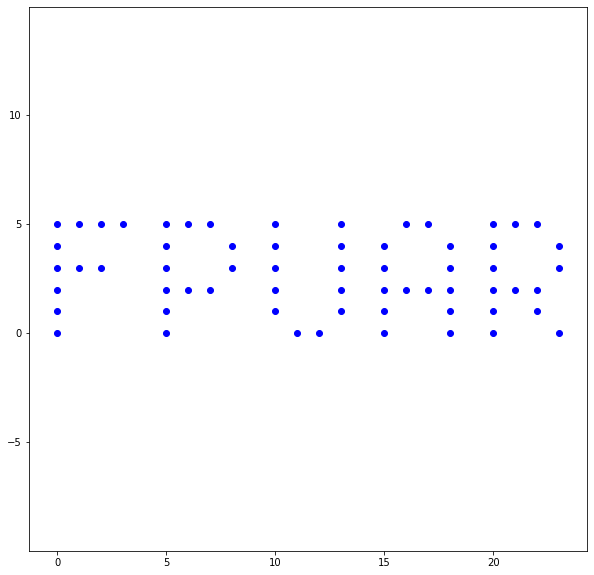

In [43]:
decode_image(image);
# FPUAR

# [Day 9: Sensor Boost](https://adventofcode.com/2019/day/9)

In [44]:
with open(input_path(9), 'r') as f:
    code9 = list(get_ints(f))

In [45]:
assert(list(Program([104,1125899906842624,99], Input([1])).genor)[-1] == 1125899906842624)

In [46]:
assert(list(Program([109,1,204,-1,1001,100,1,100,1008,100,16,101,1006,101,0,99], Input([1])).genor) == [109, 1, 204, -1, 1001, 100, 1, 100, 1008, 100, 16, 101, 1006, 101, 0, 99])

In [47]:
assert(len(str(list(Program([1102,34915192,34915192,7,4,7,99,0], Input([1])).genor)[0])) == 16)

In [48]:
list(Program(code9, Input([1])).genor)

[3345854957]

In [49]:
list(Program(code9, Input([2])).genor)

[68938]

# [Day 10: Monitoring Station](https://adventofcode.com/2019/day/10)

In [50]:
with open(input_path(10), 'r') as f:
    grid = [line.strip() for line in f]

In [51]:
print(sum(val == '#' for row in grid for val in row))

307


In [52]:
def best_monitor_station(grid):
    """find the best monitor station."""
    m, n = len(grid), len(grid[0])
    asters = [(x, y) for y in range(m) for x in range(n) if grid[y][x] == '#']
    counter = collections.Counter()
    for i, (x1, y1) in enumerate(asters):
        for j in range(i):
            x0, y0 = asters[j]
            # check if there are any asteroids between (x0, y0) and (x1, y1)
            dx, dy = x1 - x0, y1 - y0
            xmin, xmax = sorted((x0, x1))
            ymin, ymax = sorted((y0, y1))
            for k in range(len(asters)):
                if k not in (i, j):
                    x, y = asters[k]
                    if xmin <= x <= xmax and ymin <= y <= ymax and dy * (x - x0) == dx * (y - y0):
                        break
            else:
                counter[i] += 1
                counter[j] += 1
    best_idx, mx = counter.most_common(1)[0]
    return asters[best_idx], mx

In [53]:
monitor, mx = best_monitor_station(grid)
print("Best location is at ({}, {}) which connects {} asteroid.".format(monitor[0], monitor[1], mx))

Best location is at (8, 16) which connects 214 asteroid.


In [54]:
def rotate_and_vaporize(grid, monitor):
    """rotate the laser clockwise and vaporize the asteroids."""
    m, n = len(grid), len(grid[0])
    x0, y0 = monitor
    asters = [(x, y) for y in range(m) for x in range(n) if grid[y][x] == '#' and (x != x0 or y != y0)]
    removes = []
    while asters:
        cands = []
        nas = len(asters)
        next_asters = []
        for i, (x1, y1) in enumerate(asters):
            dx, dy = x1 - x0, y1 - y0
            xmin, xmax = sorted((x0, x1))
            ymin, ymax = sorted((y0, y1))
            for j in range(nas):
                if j != i:
                    x, y = asters[j]
                    if xmin <= x <= xmax and ymin <= y <= ymax and dy * (x - x0) == dx * (y - y0):
                        next_asters.append((x1, y1))
                        break
            else:
                theta = np.arctan2(-dy, dx)
                if theta < 0:
                    beta = -theta + np.pi / 2
                elif theta <= np.pi / 2:
                    beta = np.pi / 2 - theta
                else:
                    beta = np.pi * 2 - (theta - np.pi/2)
                cands.append((beta, i))
        cands.sort()
        removes.extend(asters[idx] for _, idx in cands)
        asters = next_asters
    return removes

In [55]:
removes = rotate_and_vaporize(grid, monitor)
x, y = removes[199]
print(x * 100 + y)

502


# [Day 11: Space Police](https://adventofcode.com/2019/day/11)

In [56]:
with open(input_path(11), 'r') as f:
    code11 = list(map(int, f.read().split(',')))

In [57]:
def robot_paint(code, start=0):
    """simulate robot paint."""
    pos = 0
    face = 1j
    prog = Program(code, Input([start]))
    board = collections.defaultdict(int)
    cpu = prog.genor
    while True:
        command = next(cpu, None)
        if command is None:
            break
        board[pos] = command
        command = next(cpu, None)
        if command is None:
            break
        if command == 0:
            face *= 1j
        else:
            face *= (-1j)
        pos += 1 * face
        prog.inputs.feed(board.get(pos, 0))
    return board

In [58]:
board = robot_paint(code11, start=0)
print(len(board))

2418


In [59]:
def plot_paint(board):
    """plot paint generated by the robot."""
    fig, ax = plt.subplots(figsize=(10, 10))
    for key, value in board.items():
        if value == 1:
            x = key.real
            y = key.imag
            ax.scatter(x, y, color='b')
    ax.axis('equal')
    plt.show()

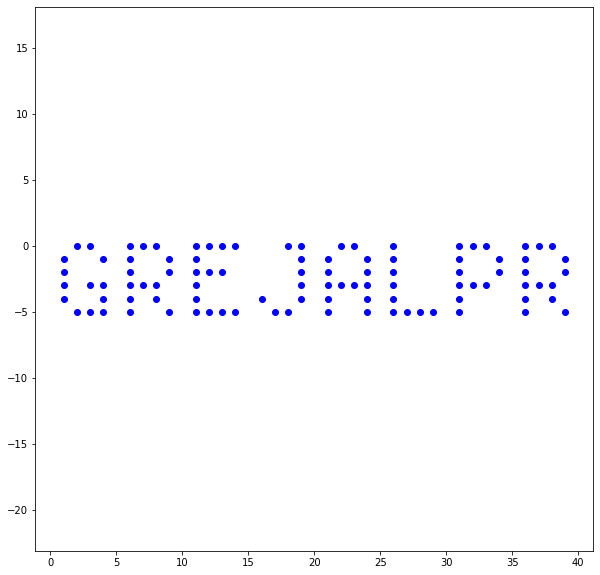

In [60]:
board = robot_paint(code11, start=1)
plot_paint(board)

# [Day 12: The N-Body Problem](https://adventofcode.com/2019/day/12)

In [61]:
with open(input_path(12), 'r') as f:
    xyzs = list(get_ints(f))

In [62]:
with open(input_path_sample(12), 'r') as f:
    xyzs_sample = list(get_ints(f))

In [63]:
def N_body_simulation(xyzs, nsteps):
    """conduct N-body simulation for nsteps, return total energy"""
    xyzs = np.array(xyzs, dtype=np.int64)
    n = 4
    dim = 3
    assert(len(xyzs) == dim * n)
    vxyzs = np.zeros(dim * n, dtype=np.int64)
    for _ in range(nsteps):
        # 1. apply acceleration
        axyzs = np.zeros(dim * n, dtype=np.int64)
        for i in range(n):
            for j in range(i + 1, n):
                for d in range(dim):
                    pi = xyzs[i * dim + d]
                    pj = xyzs[j * dim + d]
                    if pi > pj:
                        axyzs[i * dim + d] -= 1
                        axyzs[j * dim + d] += 1
                    elif pi < pj:
                        axyzs[i * dim + d] += 1
                        axyzs[j * dim + d] -= 1
        # 2. update velocity
        vxyzs += axyzs
        # 3. update position
        xyzs += vxyzs
    # compute energy
    energy = 0
    for i in range(n):
        pot = 0
        kin = 0
        for d in range(3):
            pot += abs(xyzs[i * dim + d])
            kin += abs(vxyzs[i * dim + d])
        energy += pot * kin
    return energy

In [64]:
assert(N_body_simulation(xyzs_sample, nsteps=100) == 1940)

In [65]:
print(N_body_simulation(xyzs, nsteps=1000))

8287


In [66]:
def find_first_repeat(xyzs):
    """return the first repeat step."""
    xyzs = np.array(xyzs, dtype=np.int64)
    n = 4
    dim = 3
    assert(len(xyzs) == dim * n)
    def compute_period(ps):
        """compute the period."""
        n = len(ps)
        vs = np.zeros(n, dtype=np.int64)
        seen = {(ps.tobytes(), vs.tobytes()) : 0}
        steps = 0
        while True:
            for i in range(n):
                for j in range(i + 1, n):
                    if ps[i] > ps[j]:
                        vs[i] -= 1
                        vs[j] += 1
                    elif ps[i] < ps[j]:
                        vs[i] += 1
                        vs[j] -= 1
            ps += vs
            steps += 1
            code = (ps.tobytes(), vs.tobytes())
            if code in seen:
                return seen[code], steps
            seen[code] = steps
    periods = []
    for d in range(dim):
        ps = np.zeros(n)
        for i in range(n):
            ps[i] += xyzs[i * dim + d]
        a, b = compute_period(ps)
        assert(a == 0)
        periods.append(b - a)
    ans = periods[0] * periods[1] // (math.gcd(periods[0], periods[1]))
    for d in range(2, dim):
        ans = ans * periods[d] // (math.gcd(ans, periods[d]))
    return ans

In [67]:
print(find_first_repeat(xyzs))

528250271633772


# [Day 13: Care Package](https://adventofcode.com/2019/day/13)

- 0 is an empty tile. No game object appears in this tile.
- 1 is a wall tile. Walls are indestructible barriers.
- 2 is a block tile. Blocks can be broken by the ball.
- 3 is a horizontal paddle tile. The paddle is indestructible.
- 4 is a ball tile. The ball moves diagonally and bounces off objects.

In [68]:
with open(input_path(13), 'r') as f:
    code13 = list(get_ints(f))

In [69]:
def draw_tiles(code):
    """draw tiles based on code."""
    out = list(Program(code, Input([])).genor)
    n = len(out)
    screen = {}
    for i in range(0, n, 3):
        x, y, t = out[i:i + 3]
        screen[x, y] = t
    return sum(t == 2 for t in screen.values())

In [70]:
print(draw_tiles(code13))

280


In [73]:
def play_game(code):
    """play game."""
    class GameInput:
        def __init__(self):
            self.idx = 0
            self.score = None
            self.paddle = None
            self.ball = None
            self.x = None
            self.y = None

        def next_input(self):
            assert(self.ball is not None and self.paddle is not None)
            if self.ball < self.paddle:
                return -1
            elif self.ball > self.paddle:
                return 1
            else:
                return 0
            
        def handle_out(self, data):
            """handle output."""
            if self.idx == 0:
                self.x = data
            elif self.idx == 1:
                self.y = data
            elif self.x == -1 and self.y == 0:
                self.score = data
            elif data == 3:
                self.paddle = self.x
            elif data == 4:
                self.ball = self.x
            self.idx = (self.idx + 1) % 3
                
    code[0] = 2
    game_input = GameInput()
    program = Program(code, game_input)
    genor = program.genor
    for nxt in genor:
        game_input.handle_out(nxt)
    return game_input.score

In [74]:
print(play_game(code13))

13298
